/tmp/ipykernel_3732920/1834680232.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)  # 选择5个颜色，使用 viridis 色系


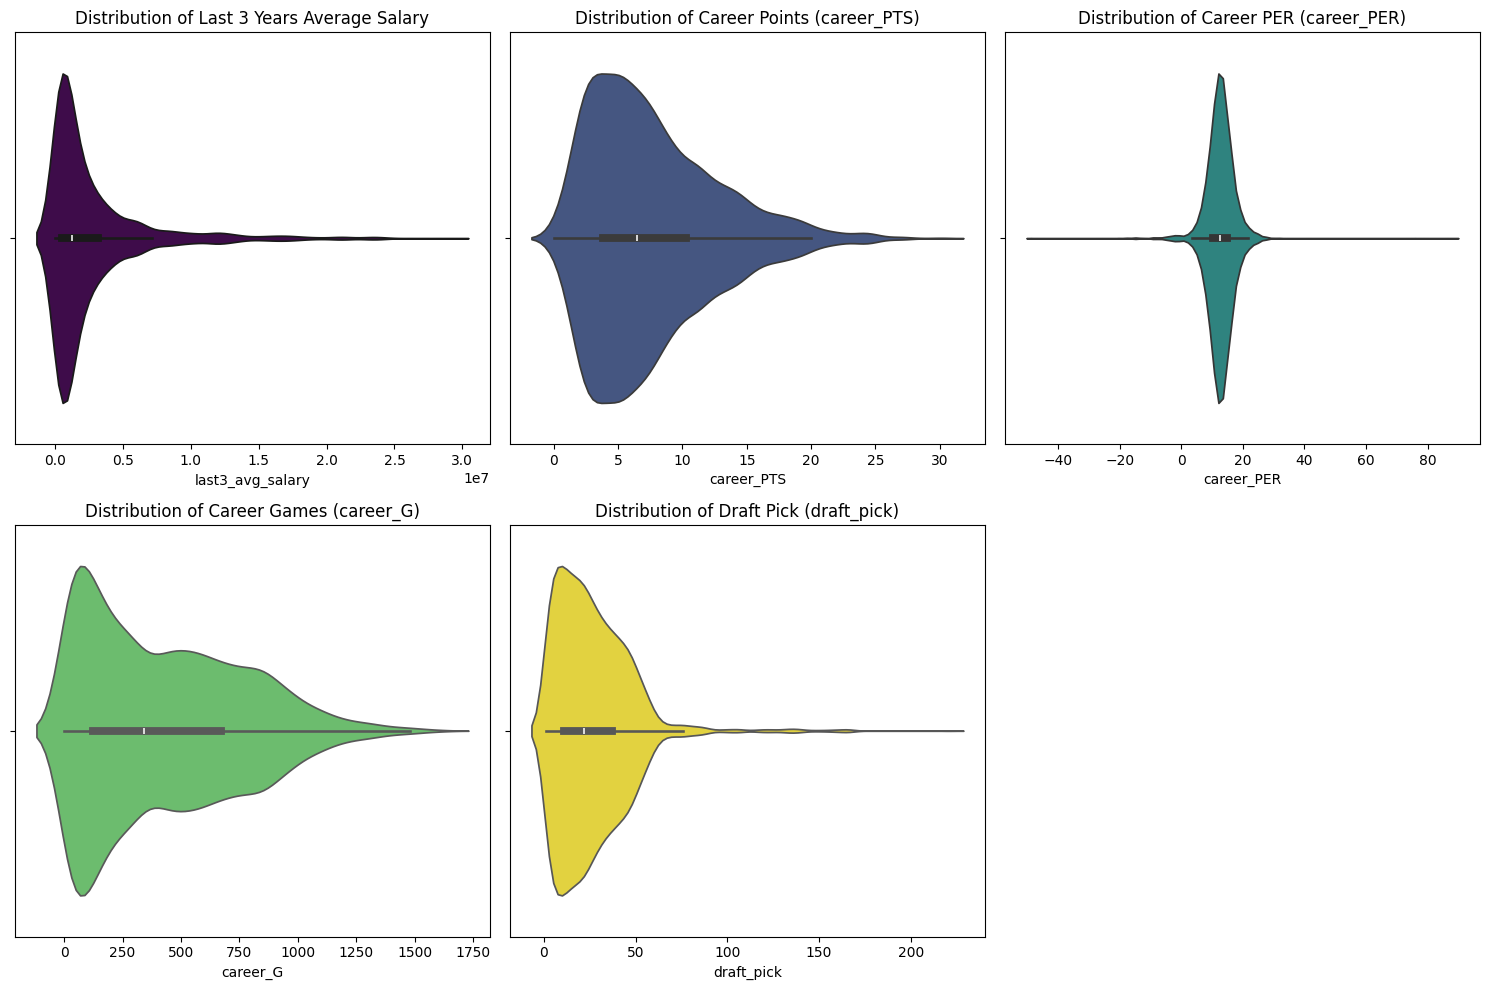

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# ---- 身高英寸转换 ----
def convert_height(height_str):
    try:
        feet, inches = height_str.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return None

merged['height_inch'] = merged['height'].apply(convert_height)

# ---- 体重数值提取 ----
merged['weight_num'] = merged['weight'].str.replace('lb', '', regex=False).astype(float)

# ---- 清洗 draft_pick 字段 ----
def clean_draft_pick(draft_pick):
    try:
        # 提取数字部分
        pick = ''.join(filter(str.isdigit, draft_pick))
        return int(pick) if pick else None
    except:
        return None

# 处理 draft_pick 字段
merged['draft_pick'] = merged['draft_pick'].apply(clean_draft_pick)

# 转换为数值的表现特征
perf_features = [
    'career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G',
    'career_PER', 'career_PTS', 'career_TRB'
]
for col in perf_features:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# ---- 取每个球员最后三年 ----
last3 = merged.groupby('player_id').apply(
    lambda x: x.sort_values('career_year', ascending=False).head(3)
).reset_index(drop=True)

# 计算每个球员最后三年的平均薪资
avg_salary = last3.groupby('player_id')['salary'].mean().reset_index(name='last3_avg_salary')

# 合并平均薪资数据
merged_last3 = last3.merge(avg_salary, on='player_id', how='left')

# ---- 绘制小提琴图 ----
plt.figure(figsize=(15, 10))

# 使用渐变色系，分别为每个小提琴图指定不同的颜色
color_map = plt.cm.get_cmap('viridis', 5)  # 选择5个颜色，使用 viridis 色系

# 小提琴图展示 last3_avg_salary 的分布
plt.subplot(2, 3, 1)
sns.violinplot(x=merged_last3['last3_avg_salary'], color=color_map(0))
plt.title('Distribution of Last 3 Years Average Salary')

# 小提琴图展示 career_PTS 的分布
plt.subplot(2, 3, 2)
sns.violinplot(x=merged_last3['career_PTS'], color=color_map(1))
plt.title('Distribution of Career Points (career_PTS)')

# 小提琴图展示 career_PER 的分布
plt.subplot(2, 3, 3)
sns.violinplot(x=merged_last3['career_PER'], color=color_map(2))
plt.title('Distribution of Career PER (career_PER)')

# 小提琴图展示 career_G 的分布
plt.subplot(2, 3, 4)
sns.violinplot(x=merged_last3['career_G'], color=color_map(3))
plt.title('Distribution of Career Games (career_G)')

# 小提琴图展示 draft_pick 的分布
plt.subplot(2, 3, 5)
sns.violinplot(x=merged_last3['draft_pick'], color=color_map(4))
plt.title('Distribution of Draft Pick (draft_pick)')

plt.tight_layout()  # 调整布局，使图形更紧凑
plt.show()

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# ---- 身高英寸转换 ----
def convert_height(height_str):
    try:
        feet, inches = height_str.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return None

merged['height_inch'] = merged['height'].apply(convert_height)

# ---- 体重数值提取 ----
merged['weight_num'] = merged['weight'].str.replace('lb', '', regex=False).astype(float)

# ---- 清洗 draft_pick 字段 ----
def clean_draft_pick(draft_pick):
    try:
        # 提取数字部分
        pick = ''.join(filter(str.isdigit, draft_pick))
        return int(pick) if pick else None
    except:
        return None

# 处理 draft_pick 字段
merged['draft_pick'] = merged['draft_pick'].apply(clean_draft_pick)

# 转换为数值的表现特征
perf_features = [
    'career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G',
    'career_PER', 'career_PTS', 'career_TRB'
]
for col in perf_features:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# ---- 取每个球员最后三年 ----
last3 = merged.groupby('player_id').apply(
    lambda x: x.sort_values('career_year', ascending=False).head(3)
).reset_index(drop=True)

avg_salary = last3.groupby('player_id')['salary'].mean().reset_index(name='last3_avg_salary')

# ---- 表现 + 身高体重 + draft_pick 特征 ----
player_stats = merged.drop_duplicates('player_id')[['player_id'] + perf_features + ['height_inch', 'weight_num', 'draft_pick']]
data = avg_salary.merge(player_stats, on='player_id').dropna()

# ---- 归一化 身高 & 体重 ----
data['height_inch'] = (data['height_inch'] - data['height_inch'].min()) / data['height_inch'].max()
data['weight_num'] = (data['weight_num'] - data['weight_num'].min()) / data['weight_num'].max()

In [32]:
data

,player_id,last3_avg_salary,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,height_inch,weight_num,draft_pick
0,abdelal01,6.516667e+05,0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,0.208791,0.329231,25.0
1,abdulka01,2.343333e+06,3.6,55.9,5.6,72.1,1560,24.6,24.6,11.2,0.252747,0.283077,1.0
2,abdulma02,2.399500e+06,3.5,44.2,35.4,90.5,586,15.4,14.6,1.9,0.109890,0.089231,3.0
3,abdulta01,4.125000e+06,1.1,41.7,23.7,70.3,236,11.4,7.8,3.3,0.164835,0.276923,11.0
4,abdursh01,5.933333e+06,2.5,47.2,29.7,81.0,830,19.0,18.1,7.5,0.197802,0.283077,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,zellety01,4.108838e+06,0.9,50.9,28.6,76.4,412,14.9,7.0,4.4,0.230769,0.369231,17.0
2402,zhizhwa01,1.121996e+06,0.3,41.7,38.5,73.5,137,14.2,4.4,1.7,0.230769,0.375385,36.0
2403,zidekge01,6.937333e+05,0.2,40.8,25.0,78.3,135,8.7,3.4,2.1,0.230769,0.360000,22.0
2405,zipsepa01,1.031306e+06,0.8,37.1,33.5,76.9,98,6.1,4.7,2.6,0.186813,0.252308,48.0


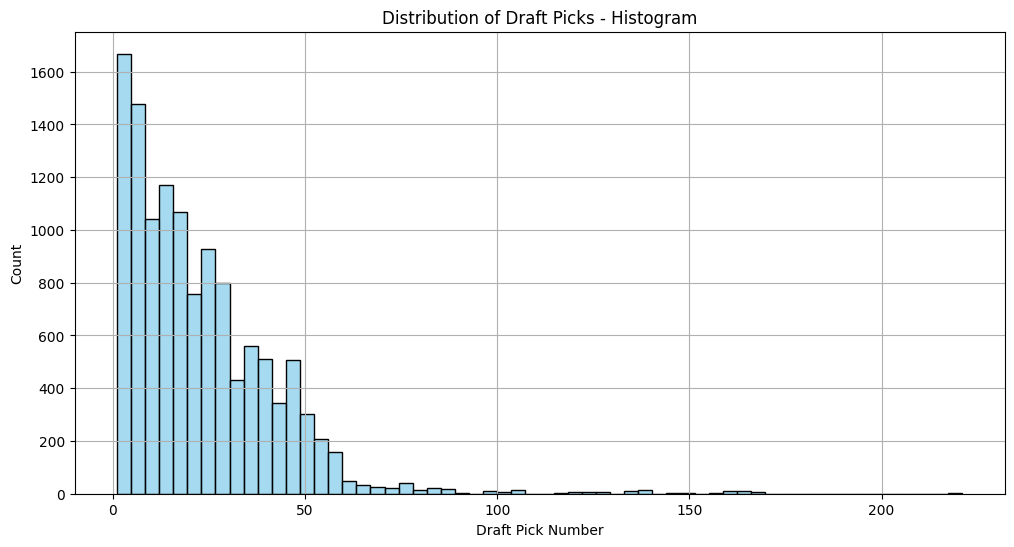

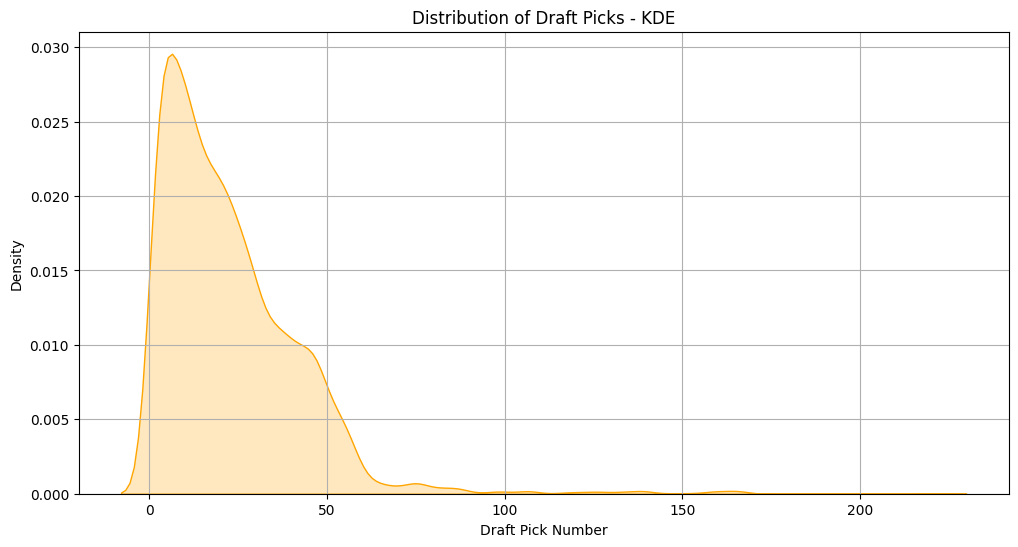

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')

# ---- 清洗 draft_pick 字段 ----
def clean_draft_pick(draft_pick):
    try:
        pick = ''.join(filter(str.isdigit, str(draft_pick)))
        return int(pick) if pick else None
    except:
        return None

merged['draft_pick'] = merged['draft_pick'].apply(clean_draft_pick)

# 只保留有顺位信息的数据
valid_draft = merged.dropna(subset=['draft_pick'])

# ---- 可视化 draft_pick 分布 ----
plt.figure(figsize=(12, 6))

# 条状图（Histogram）
sns.histplot(valid_draft['draft_pick'], bins=60, kde=False, color='skyblue')
plt.title('Distribution of Draft Picks - Histogram')
plt.xlabel('Draft Pick Number')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 核密度估计图（KDE）
plt.figure(figsize=(12, 6))
sns.kdeplot(valid_draft['draft_pick'], fill=True, color='orange')
plt.title('Distribution of Draft Picks - KDE')
plt.xlabel('Draft Pick Number')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [39]:
# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
# 清洗 draft_pick 字段
def clean_draft_pick(draft_pick):
    try:
        pick = ''.join(filter(str.isdigit, str(draft_pick)))
        return int(pick) if pick else None
    except:
        return None

merged['draft_pick'] = merged['draft_pick'].apply(clean_draft_pick)

# 去除缺失值
valid_draft = merged['draft_pick'].dropna()

# 计算统计量（含10th和50th百分位）
summary_stats = {
    'min': valid_draft.min(),
    'max': valid_draft.max(),
    'mean': valid_draft.mean(),
    '10th_percentile': valid_draft.quantile(0.10),
    '50th_percentile (median)': valid_draft.quantile(0.50)
}

# 打印结果
for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}")


min: 1.00
max: 221.00
mean: 22.67
10th_percentile: 3.00
50th_percentile (median): 18.00


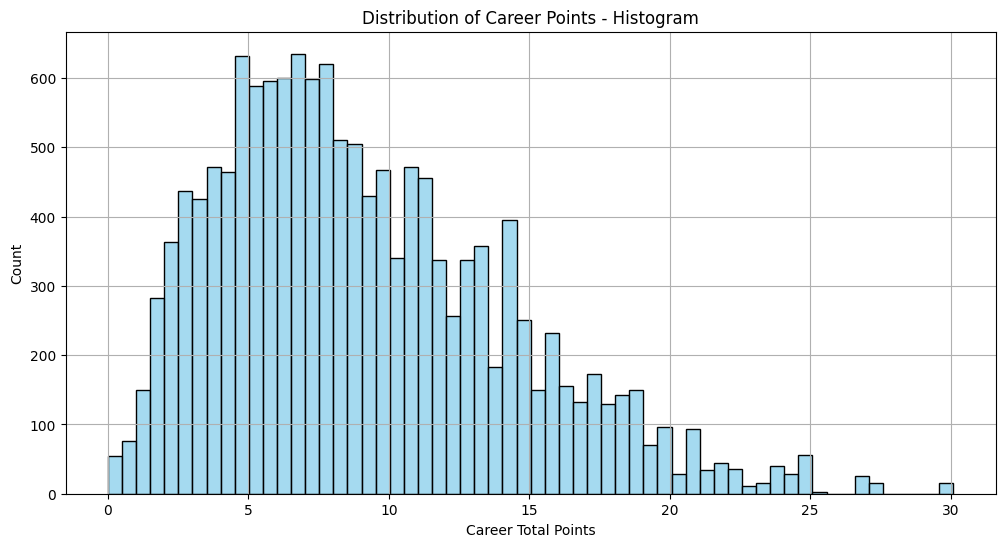

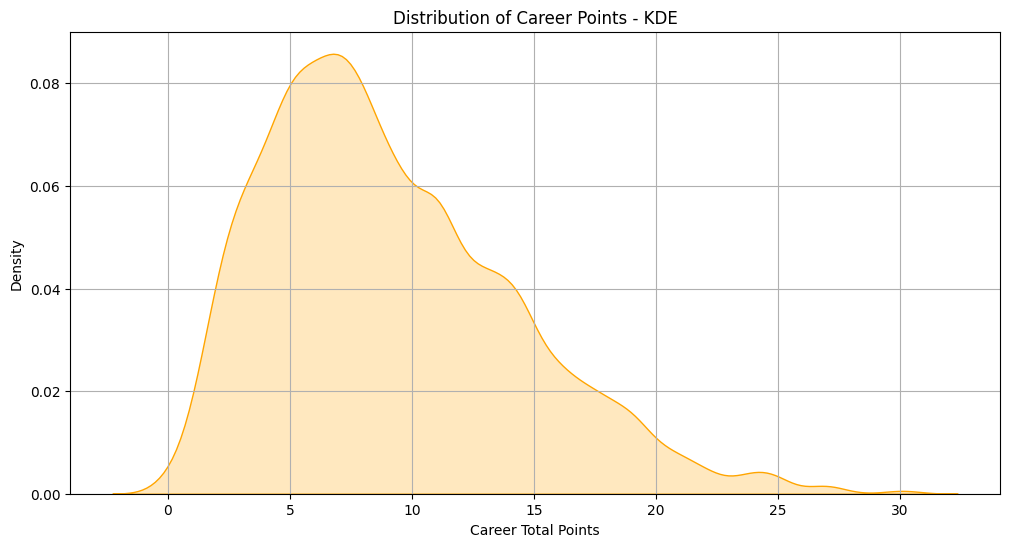

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')

# ---- 分析 career_PTS 分布 ----
# 去除无效的得分数据
valid_pts = merged.dropna(subset=['career_PTS'])

# 条状图（Histogram）
plt.figure(figsize=(12, 6))
sns.histplot(valid_pts['career_PTS'], bins=60, kde=False, color='skyblue')
plt.title('Distribution of Career Points - Histogram')
plt.xlabel('Career Total Points')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 核密度估计图（KDE）
plt.figure(figsize=(12, 6))
sns.kdeplot(valid_pts['career_PTS'], fill=True, color='orange')
plt.title('Distribution of Career Points - KDE')
plt.xlabel('Career Total Points')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [49]:
import pandas as pd

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')

# 去除缺失值
valid_pts = merged['career_PTS'].dropna()

# 计算统计量
summary_stats = {
    'min': valid_pts.min(),
    'max': valid_pts.max(),
    'mean': valid_pts.mean(),
    '90th_percentile (top 10%) threshold': valid_pts.quantile(0.90),
    '50th_percentile (top 50%) threshold': valid_pts.quantile(0.50)
}

# 打印结果
for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}")


min: 0.00
max: 30.10
mean: 9.11
90th_percentile (top 10%) threshold: 16.20
50th_percentile (top 50%) threshold: 8.20


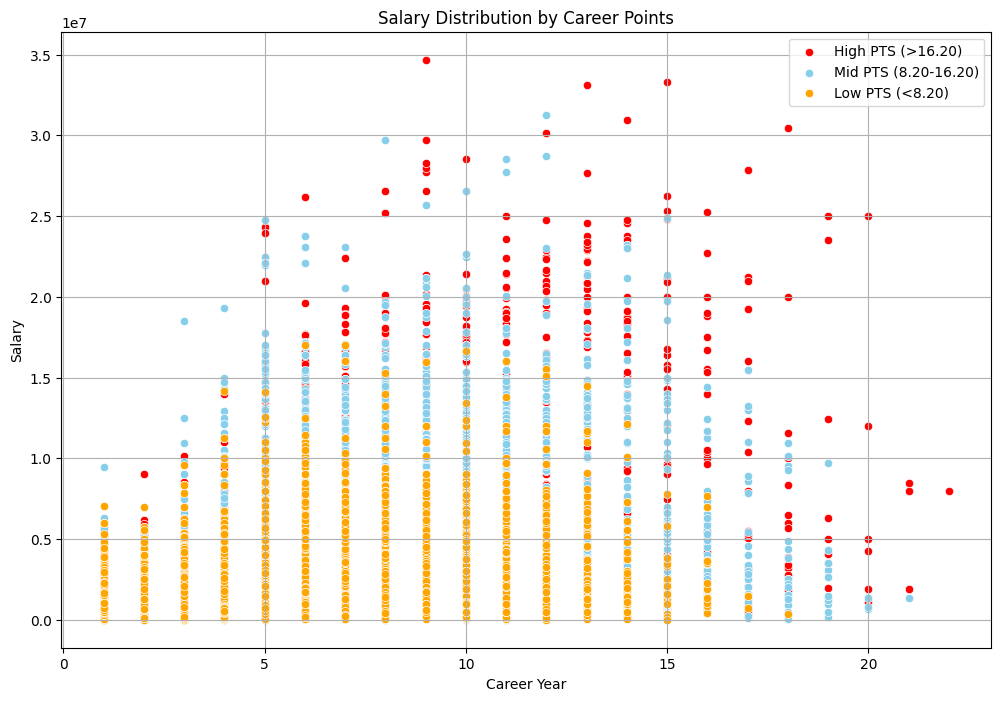

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# ---- 按得分分组 ----
high_pts = merged[merged['career_PTS'] > 16.20]
mid_pts = merged[(merged['career_PTS'] <= 16.20) & (merged['career_PTS'] > 8.20)]
low_pts = merged[merged['career_PTS'] <= 8.20]

# 可视化
plt.figure(figsize=(12, 8))

# 绘制高得分球员的薪资分布
sns.scatterplot(x='career_year', y='salary', data=high_pts, label='High PTS (>16.20)', color='red')

# 绘制中等得分球员的薪资分布
sns.scatterplot(x='career_year', y='salary', data=mid_pts, label='Mid PTS (8.20-16.20)', color='skyblue')

# 绘制低得分球员的薪资分布
sns.scatterplot(x='career_year', y='salary', data=low_pts, label='Low PTS (<8.20)', color='orange')

plt.title('Salary Distribution by Career Points')
plt.xlabel('Career Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()


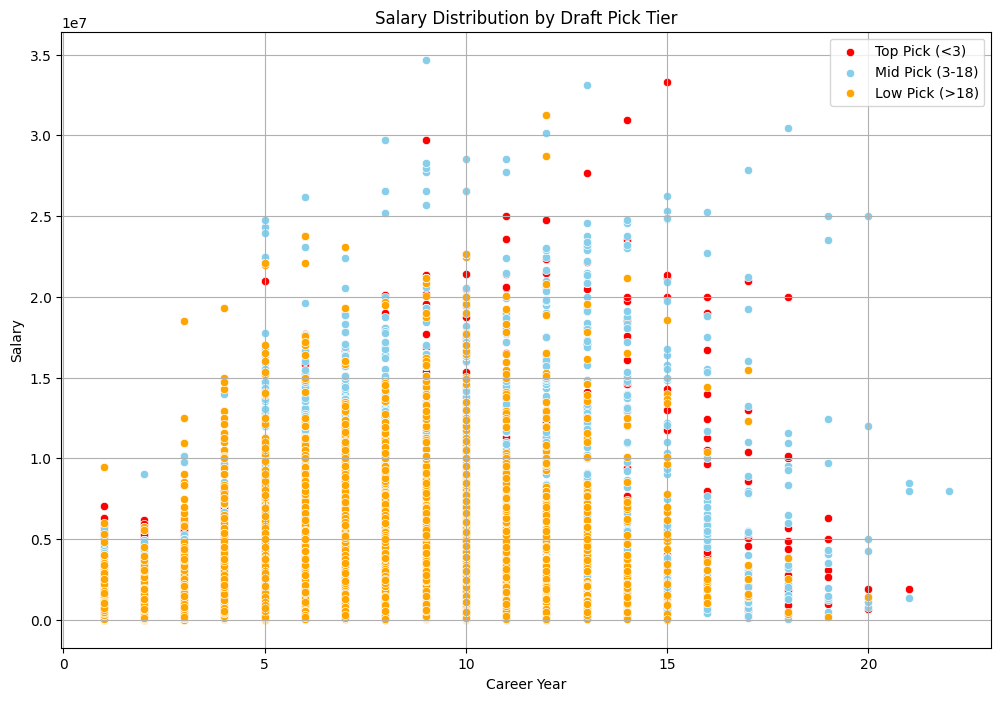

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# ---- 清洗 draft_pick 字段 ----
def clean_draft_pick(draft_pick):
    try:
        pick = ''.join(filter(str.isdigit, str(draft_pick)))
        return int(pick) if pick else None
    except:
        return None

merged['draft_pick'] = merged['draft_pick'].apply(clean_draft_pick)

# 分组
top_pick = merged[merged['draft_pick'] < 3]
mid_pick = merged[(merged['draft_pick'] >= 3) & (merged['draft_pick'] <= 18)]
late_pick = merged[merged['draft_pick'] > 18]

# 可视化
plt.figure(figsize=(12, 8))

sns.scatterplot(x='career_year', y='salary', data=top_pick, label='Top Pick (<3)', color='red')
sns.scatterplot(x='career_year', y='salary', data=mid_pick, label='Mid Pick (3-18)', color='skyblue')
sns.scatterplot(x='career_year', y='salary', data=late_pick, label='Low Pick (>18)', color='orange')

plt.title('Salary Distribution by Draft Pick Tier')
plt.xlabel('Career Year')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# 找到 top_pick 中 career_year 最大的值
max_year = top_pick['career_year'].max()

# 筛选 career_year 等于最大值的记录
max_career_top_pick = top_pick[top_pick['career_year'] == max_year]

# 按 salary 升序排序，找到薪资最低的那一条
lowest_salary_entry = max_career_top_pick.sort_values(by='salary').iloc[0]

# 打印该球员的所有信息
print("异常点对应球员信息：")
print(lowest_salary_entry)

# 如果你只关心几个关键字段：
print("\n关键字段：")
print("Name:", lowest_salary_entry['name'])
print("Draft Pick:", lowest_salary_entry['draft_pick'])
print("Career Year:", lowest_salary_entry['career_year'])
print("Salary:", lowest_salary_entry['salary'])
print("Season Start:", lowest_salary_entry['season_start'])


异常点对应球员信息：
index_x                                                      3582
league                                                        NBA
player_id                                               duncati01
salary                                                    1881250
season                                                    2017-18
season_end                                                   2018
season_start                                                 2017
team                                            San Antonio Spurs
index_y                                                      1117
_id                                                     duncati01
birthDate                                          April 25, 1976
birthPlace                            St. Croix, U.S. VirgIslands
career_AST                                                    3.0
career_FG%                                                   50.6
career_FG3%                                                  17.9

In [55]:
# 找到late pick中单个salary值最大的那条记录
max_salary_record = late_pick.loc[late_pick['salary'].idxmax()]

max_salary_record

index_x                                      8731
league                                        NBA
player_id                               millspa01
salary                                   31269231
season                                    2017-18
season_end                                   2018
season_start                                 2017
team                               Denver Nuggets
index_y                                      2858
_id                                     millspa01
birthDate                       February 10, 1985
birthPlace                      Monroe, Louisiana
career_AST                                    2.3
career_FG%                                   49.1
career_FG3%                                  33.4
career_FT%                                   73.4
career_G                                      945
career_PER                                   19.0
career_PTS                                   14.1
career_TRB                                    7.4


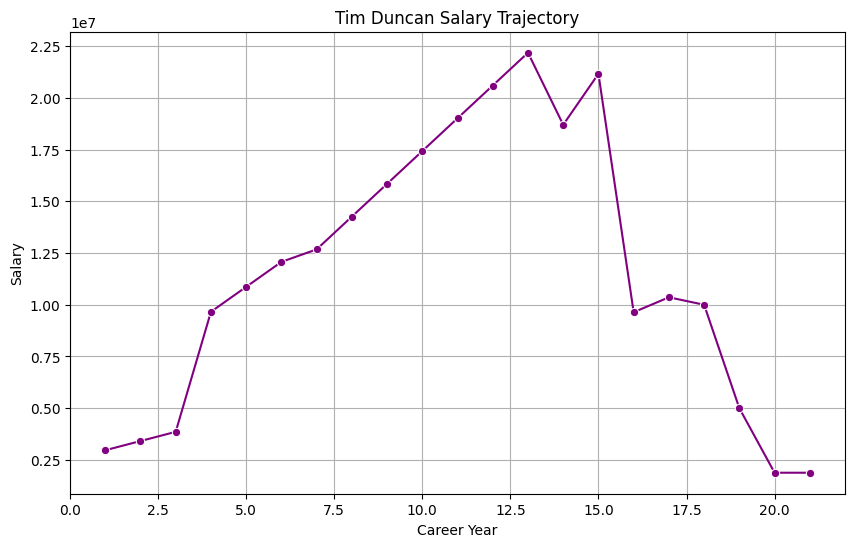

In [46]:
# 筛选出该球员的所有数据
tim_duncan_data = merged[merged['player_id'] == 'duncati01']

# 按 career_year 排序（保险起见）
tim_duncan_data = tim_duncan_data.sort_values('career_year')

# 可视化薪资轨迹
plt.figure(figsize=(10, 6))
sns.lineplot(x='career_year', y='salary', data=tim_duncan_data, marker='o', color='purple')
plt.title('Tim Duncan Salary Trajectory')
plt.xlabel('Career Year')
plt.ylabel('Salary')
plt.grid(True)
plt.show()


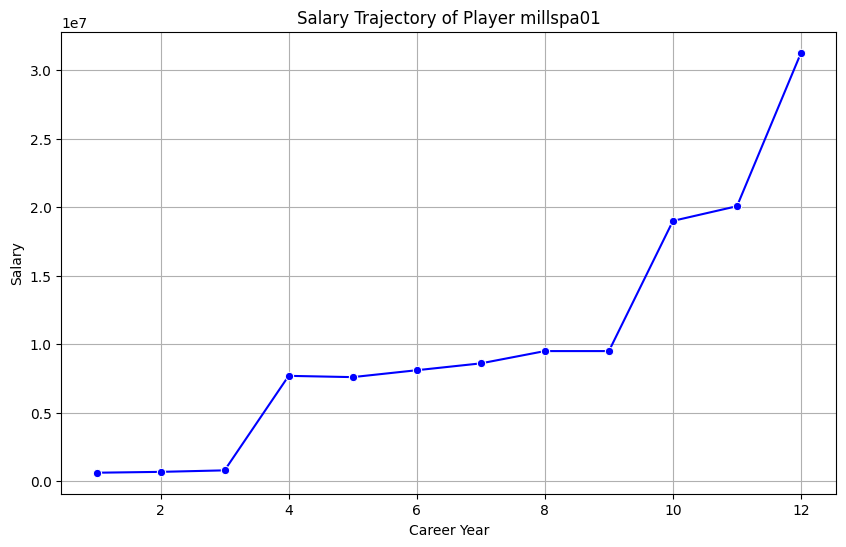

In [56]:
# 找到player_id为'millspa01'的所有记录
player_data = merged[merged['player_id'] == 'millspa01']

# 绘制薪资轨迹
plt.figure(figsize=(10, 6))
sns.lineplot(x='career_year', y='salary', data=player_data, marker='o', color='blue')

# 设置图表标题和标签
plt.title('Salary Trajectory of Player millspa01')
plt.xlabel('Career Year')
plt.ylabel('Salary')
plt.grid(True)
plt.show()


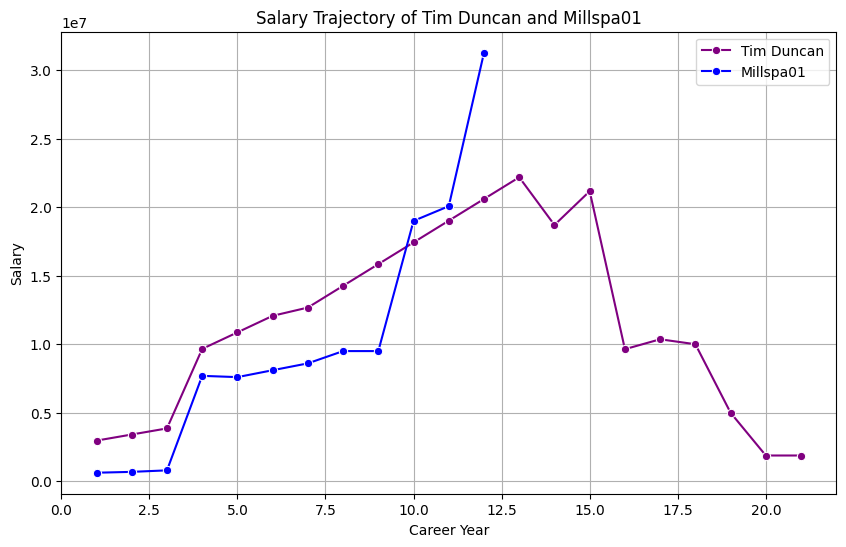

In [57]:
# 筛选出两位球员的数据
tim_duncan_data = merged[merged['player_id'] == 'duncati01']
millspa01_data = merged[merged['player_id'] == 'millspa01']

# 按 career_year 排序（保险起见）
tim_duncan_data = tim_duncan_data.sort_values('career_year')
millspa01_data = millspa01_data.sort_values('career_year')

# 可视化两位球员的薪资轨迹
plt.figure(figsize=(10, 6))

# 绘制Tim Duncan的薪资轨迹
sns.lineplot(x='career_year', y='salary', data=tim_duncan_data, marker='o', color='purple', label='Tim Duncan')

# 绘制Millspa01的薪资轨迹
sns.lineplot(x='career_year', y='salary', data=millspa01_data, marker='o', color='blue', label='Millspa01')

# 设置图表标题和标签
plt.title('Salary Trajectory of Tim Duncan and Millspa01')
plt.xlabel('Career Year')
plt.ylabel('Salary')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# ---- 身高英寸转换 ----
def convert_height(height_str):
    try:
        feet, inches = height_str.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return None

merged['height_inch'] = merged['height'].apply(convert_height)

# ---- 体重数值提取 ----
merged['weight_num'] = merged['weight'].str.replace('lb', '', regex=False).astype(float)

# ---- 清洗 draft_pick 字段 ----
def clean_draft_pick(draft_pick):
    try:
        # 提取数字部分
        pick = ''.join(filter(str.isdigit, draft_pick))
        return int(pick) if pick else None
    except:
        return None

# 处理 draft_pick 字段
merged['draft_pick'] = merged['draft_pick'].apply(clean_draft_pick)

# 转换为数值的表现特征
perf_features = [
    'career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G',
    'career_PER', 'career_PTS', 'career_TRB'
]
for col in perf_features:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# ---- 取每个球员最后三年 ----
last3 = merged.groupby('player_id').apply(
    lambda x: x.sort_values('career_year', ascending=False).head(3)
).reset_index(drop=True)

avg_salary = last3.groupby('player_id')['salary'].mean().reset_index(name='last5_avg_salary')

# ---- 表现 + 身高体重 + draft_pick 特征 ----
player_stats = merged.drop_duplicates('player_id')[['player_id'] + perf_features + ['height_inch', 'weight_num', 'draft_pick']]
data = avg_salary.merge(player_stats, on='player_id').dropna()

# ---- 归一化 身高 & 体重 ----
data['height_inch'] = (data['height_inch'] - data['height_inch'].min()) / data['height_inch'].max()
data['weight_num'] = (data['weight_num'] - data['weight_num'].min()) / data['weight_num'].max()

In [59]:
data

,player_id,last5_avg_salary,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,height_inch,weight_num,draft_pick
0,abdelal01,6.516667e+05,0.3,50.2,0.0,70.1,256,13.0,5.7,3.3,0.208791,0.329231,25.0
1,abdulka01,2.343333e+06,3.6,55.9,5.6,72.1,1560,24.6,24.6,11.2,0.252747,0.283077,1.0
2,abdulma02,2.399500e+06,3.5,44.2,35.4,90.5,586,15.4,14.6,1.9,0.109890,0.089231,3.0
3,abdulta01,4.125000e+06,1.1,41.7,23.7,70.3,236,11.4,7.8,3.3,0.164835,0.276923,11.0
4,abdursh01,5.933333e+06,2.5,47.2,29.7,81.0,830,19.0,18.1,7.5,0.197802,0.283077,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,zellety01,4.108838e+06,0.9,50.9,28.6,76.4,412,14.9,7.0,4.4,0.230769,0.369231,17.0
2402,zhizhwa01,1.121996e+06,0.3,41.7,38.5,73.5,137,14.2,4.4,1.7,0.230769,0.375385,36.0
2403,zidekge01,6.937333e+05,0.2,40.8,25.0,78.3,135,8.7,3.4,2.1,0.230769,0.360000,22.0
2405,zipsepa01,1.031306e+06,0.8,37.1,33.5,76.9,98,6.1,4.7,2.6,0.186813,0.252308,48.0


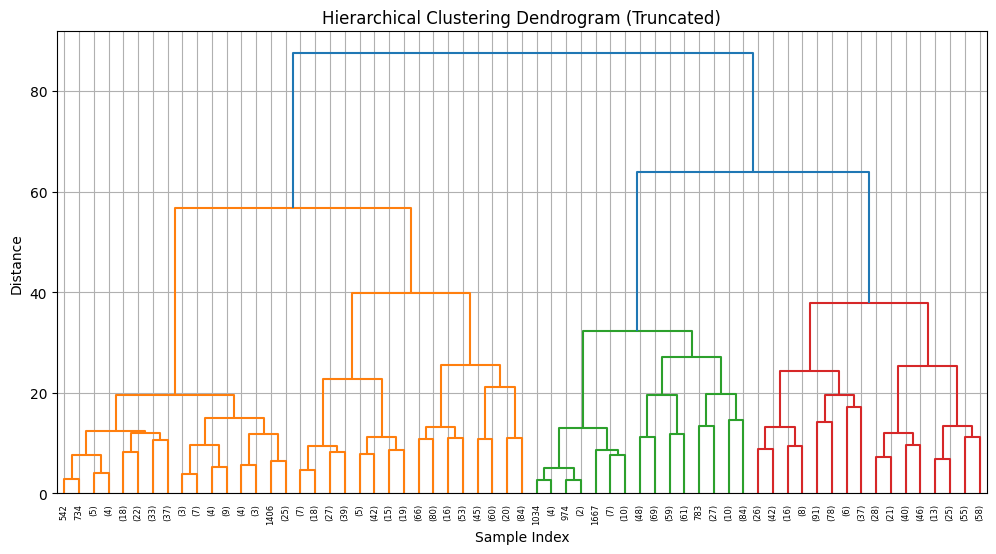

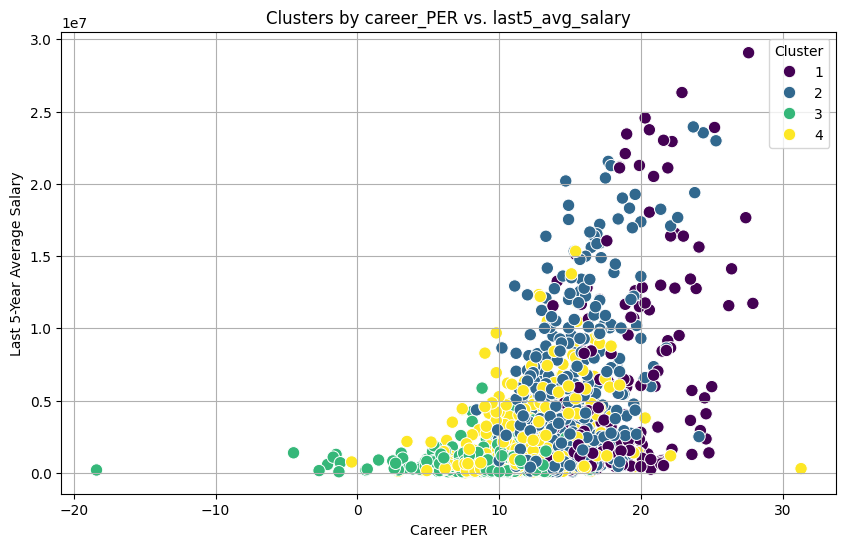

In [67]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch

# 选择用于聚类的特征
features_for_clustering = [
    'career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G',
    'career_PER', 'career_PTS', 'career_TRB',
    'height_inch', 'weight_num', 'draft_pick'
]

# 去除缺失值（保险）
cluster_data = data[features_for_clustering].dropna()

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

# 层次聚类计算 linkage matrix
linked = linkage(X_scaled, method='ward')

# 绘制树状图（dendrogram）
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # p=5 表示只展示前5层
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# 选定一个聚类数，比如分成4类
data['cluster'] = fcluster(linked, t=4, criterion='maxclust')

# 可视化聚类分布（以PER和salary为例）
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='career_PER', y='last5_avg_salary', hue='cluster', palette='viridis', s=80)
plt.title('Clusters by career_PER vs. last5_avg_salary')
plt.xlabel('Career PER')
plt.ylabel('Last 5-Year Average Salary')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


In [66]:
print(player_features.shape)


(0, 27)


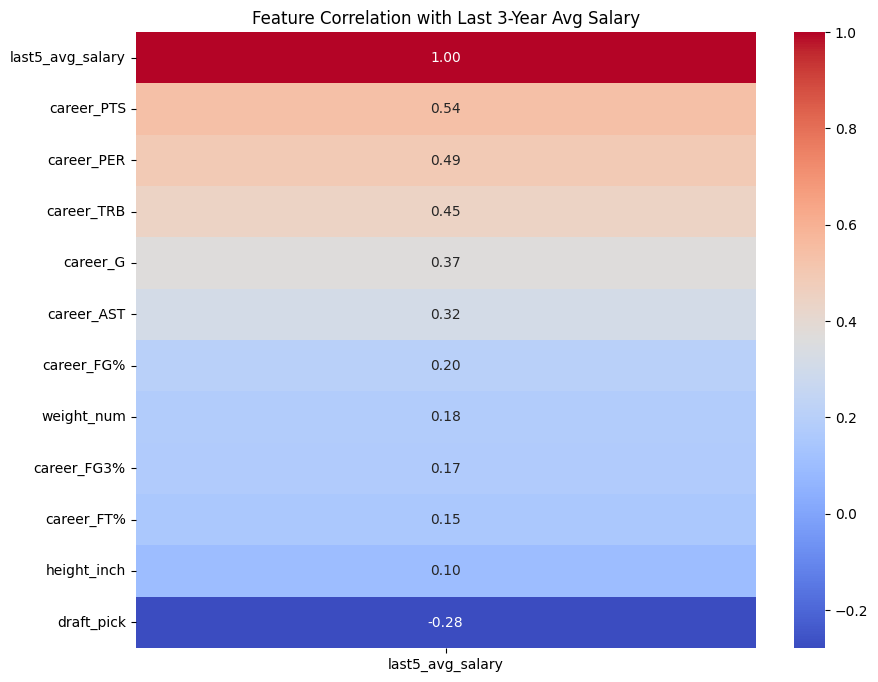

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corr = data.drop(columns='player_id').corr()  # 计算相关系数矩阵

plt.figure(figsize=(10, 8))
sns.heatmap(corr[['last5_avg_salary']].sort_values('last5_avg_salary', ascending=False), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Last 3-Year Avg Salary")
plt.show()

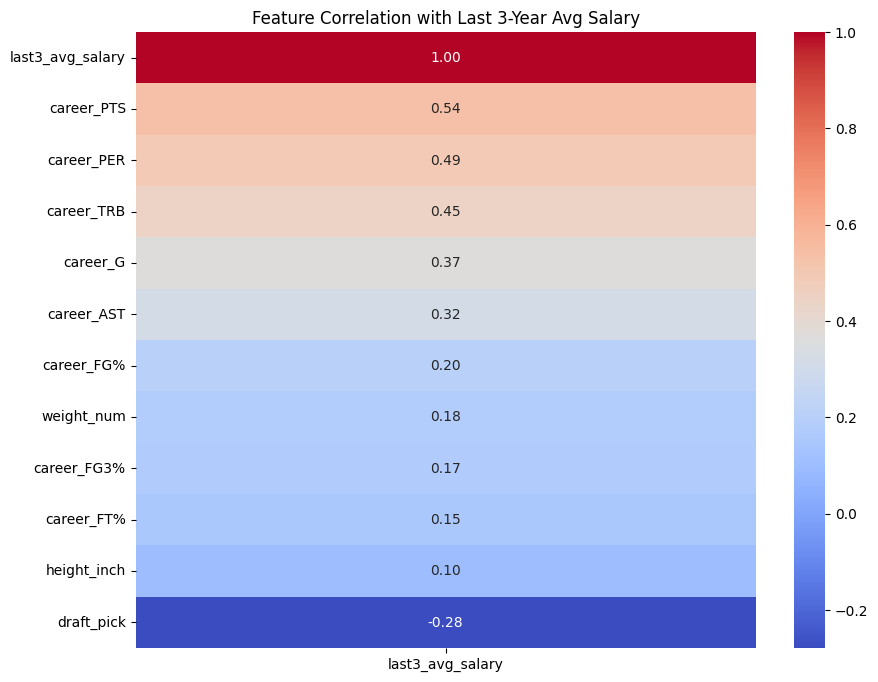

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corr = data.drop(columns='player_id').corr()  # 计算相关系数矩阵

plt.figure(figsize=(10, 8))
sns.heatmap(corr[['last3_avg_salary']].sort_values('last3_avg_salary', ascending=False), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Last 3-Year Avg Salary")
plt.show()

/tmp/ipykernel_3732920/389720000.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='Blues_d')


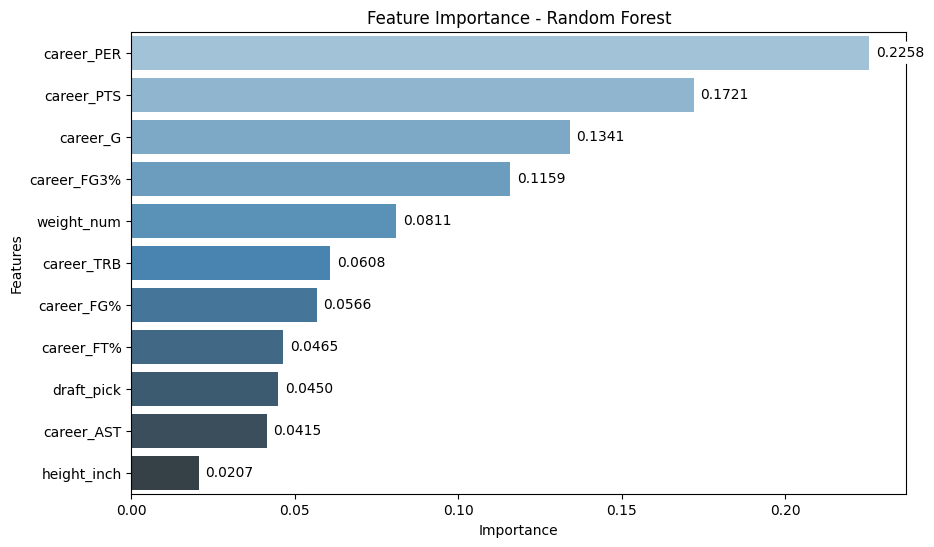

        feature  importance
5    career_PER    0.225764
6    career_PTS    0.172103
4      career_G    0.134128
2   career_FG3%    0.115852
9    weight_num    0.081080
7    career_TRB    0.060793
1    career_FG%    0.056648
3    career_FT%    0.046503
10   draft_pick    0.044967
0    career_AST    0.041464
8   height_inch    0.020698


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ---- 使用 RandomForestRegressor 分析特征重要性 ----
X = data.drop(columns=['player_id', 'last3_avg_salary'])
y = data['last3_avg_salary']

# 初始化并训练随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 获取特征重要性
feature_importances = model.feature_importances_

# 将特征和重要性配对，并排序
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# ---- 绘制条形图 ----
plt.figure(figsize=(10, 6))  # 调整图形的尺寸
ax = sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='Blues_d')

# 获取 x 轴范围
x_min, x_max = ax.get_xlim()

# 在每条 bar 上显示数值
for i in range(len(feature_importance_df)):
    # 动态设置文本位置
    ax.text(feature_importance_df['importance'].iloc[i] + 0.002,  # x 坐标稍微偏移条形图的右侧
            i,  # y 坐标
            f'{feature_importance_df["importance"].iloc[i]:.4f}',  # 显示小数点后 4 位
            va='center',  # 垂直居中对齐
            color='black',  # 文字颜色
            fontsize=10,  # 字体大小
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  # 添加背景框
            )

plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# 打印重要性排名
print(feature_importance_df)


Test RMSE: 3531464.5223155804


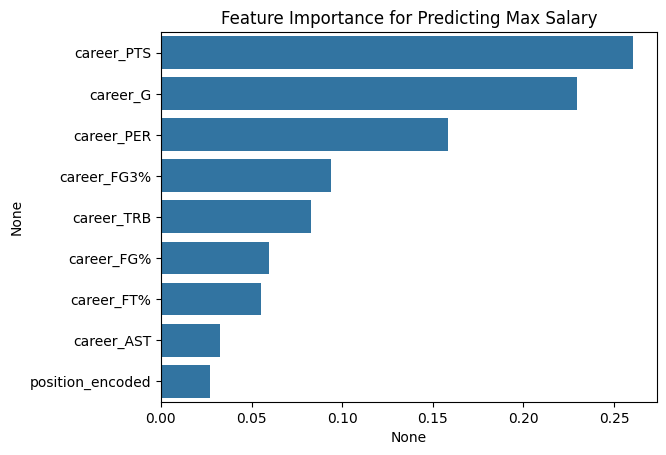

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# 加载数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')

# 类型转换
for col in ['career_PER', 'career_AST', 'career_FG%', 'career_FG3%', 'career_FT%',
            'career_G', 'career_PTS', 'career_TRB', 'career_WS', 'career_eFG%']:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

# 只保留有完整数据的记录
merged_clean = merged.dropna(subset=['career_PER', 'career_AST', 'career_FG%', 'career_FG3%',
                                     'career_FT%', 'career_G', 'career_PTS', 'career_TRB', 'salary'])

# 提取每个球员的生涯最高薪资
max_salary = merged_clean.groupby('player_id')['salary'].max().reset_index()
max_salary.columns = ['player_id', 'max_salary']

# 合并表现数据（去重）
player_features = merged_clean.drop_duplicates(subset='player_id')[[
    'player_id', 'position', 'career_AST', 'career_FG%', 'career_FG3%', 'career_FT%',
    'career_G', 'career_PER', 'career_PTS', 'career_TRB'
]]

# 合并数据
data = player_features.merge(max_salary, on='player_id')

# 编码 position
le = LabelEncoder()
data['position_encoded'] = le.fit_transform(data['position'])

# 构建训练数据
X = data[['career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G',
          'career_PER', 'career_PTS', 'career_TRB', 'position_encoded']]
y = data['max_salary']

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 建模
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 评估
y_pred = model.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# 特征重要性
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance for Predicting Max Salary")
plt.show()


In [1]:
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')
merged['career_PER'] = pd.to_numeric(merged['career_PER'], errors='coerce')
print(merged['career_PER'].isna().sum())

# 添加球龄字段（方便对齐生涯年份）
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# 过滤前N年（如前5年）用于建模
N = 30
trajectory_df = merged[merged['career_year'] <= N]



3


In [7]:
max(trajectory_df['career_year'])

22

In [2]:
# 1. 统计出现频率最高的前10个 position
top_positions = trajectory_df['position'].value_counts().head(18).index.tolist()
print("Top 10 most common positions:")
print(trajectory_df['position'].value_counts())

# 2. 过滤数据，只保留这10种 position 的记录
trajectory_df = trajectory_df[trajectory_df['position'].isin(top_positions)]


Top 10 most common positions:
position
Center                                                                1909
Point Guard                                                           1767
Power Forward and Center                                              1165
Shooting Guard                                                        1156
Small Forward                                                         1069
Power Forward                                                         1060
Center and Power Forward                                               957
Small Forward and Shooting Guard                                       810
Point Guard and Shooting Guard                                         804
Shooting Guard and Point Guard                                         765
Shooting Guard and Small Forward                                       728
Power Forward and Small Forward                                        658
Small Forward and Power Forward                              

In [3]:
trajectory_df

,index_x,league,player_id,salary,season,season_end,season_start,team,index_y,_id,...,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight,career_year
0,0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,1
1,1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,2
2,2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,3
3,3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,4
4,4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,14158,NBA,zipsepa01,750000,2016-17,2017,2016,Chicago Bulls,4679,zipsepa01,...,2nd round,Chicago Bulls,2016,6-8,NaN,Paul Zipser,Small Forward,Right,215lb,1
14159,14159,NBA,zipsepa01,1312611,2017-18,2018,2017,Chicago Bulls,4679,zipsepa01,...,2nd round,Chicago Bulls,2016,6-8,NaN,Paul Zipser,Small Forward,Right,215lb,2
14160,14160,NBA,zizican01,1645200,2017-18,2018,2017,Cleveland Cavaliers,4680,zizican01,...,1st round,Boston Celtics,2016,6-11,NaN,Ante Zizic,Center,Right,254lb,1
14161,14161,NBA,zubaciv01,1034956,2016-17,2017,2016,Los Angeles Lakers,4683,zubaciv01,...,2nd round,Los Angeles Lakers,2016,7-1,NaN,Ivica Zubac,Center,Right,240lb,1


In [4]:
trajectory_df[trajectory_df['name'] == 'Kobe Bryant']


,index_x,league,player_id,salary,season,season_end,season_start,team,index_y,_id,...,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight,career_year
1777,1777,NBA,bryanko01,1015000,1996-97,1997,1996,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,1
1778,1778,NBA,bryanko01,1167240,1997-98,1998,1997,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,2
1779,1779,NBA,bryanko01,1319000,1998-99,1999,1998,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,3
1780,1780,NBA,bryanko01,9000000,1999-00,2000,1999,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,4
1781,1781,NBA,bryanko01,10130000,2000-01,2001,2000,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,5
1782,1782,NBA,bryanko01,11250000,2001-02,2002,2001,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,6
1783,1783,NBA,bryanko01,12375000,2002-03,2003,2002,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,7
1784,1784,NBA,bryanko01,13500000,2003-04,2004,2003,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,8
1785,1785,NBA,bryanko01,14175000,2004-05,2005,2004,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,9
1786,1786,NBA,bryanko01,15946875,2005-06,2006,2005,Los Angeles Lakers,550,bryanko01,...,1st round,Charlotte Hornets,1996,6-6,"Lower Merion in Ardmore, Pennsylvania",Kobe Bryant,Shooting Guard and Small Forward,Right,212lb,10


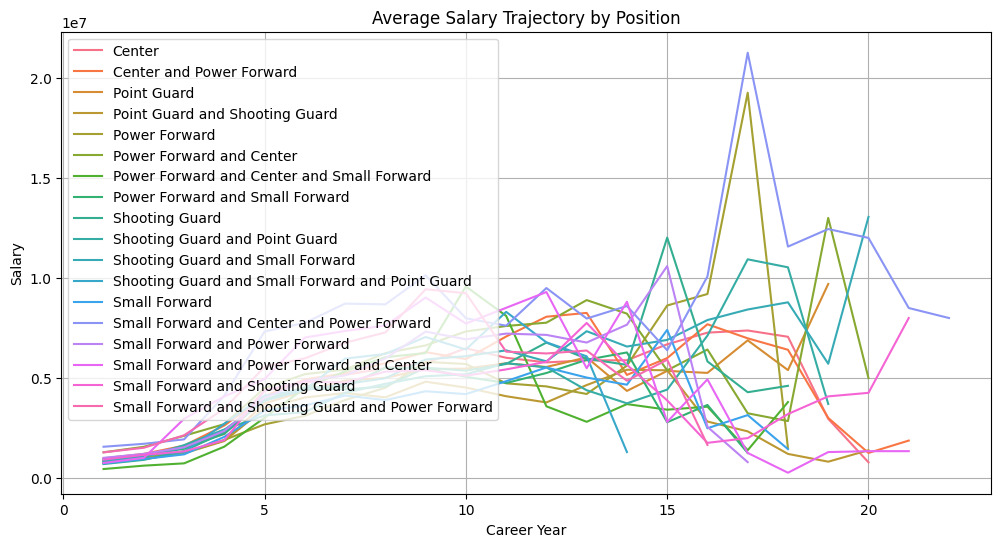

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 平均轨迹（按位置）
avg_traj = trajectory_df.groupby(['position', 'career_year']).agg({
    'salary': 'mean',
    'career_PER': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_traj, x='career_year', y='salary', hue='position')
plt.title("Average Salary Trajectory by Position")
plt.xlabel("Career Year")
plt.ylabel("Salary")
plt.grid(True)
plt.legend(loc='upper left')

plt.show()


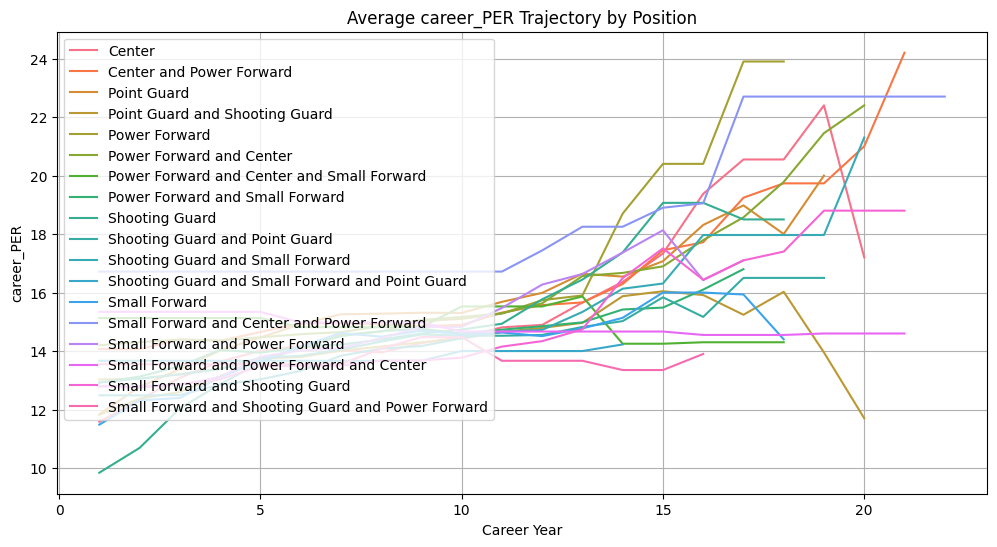

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_traj, x='career_year', y='career_PER', hue='position')
plt.title("Average career_PER Trajectory by Position")
plt.xlabel("Career Year")
plt.ylabel("career_PER")
plt.grid(True)
plt.legend(loc='upper left')

plt.show()

/home/intern/miniconda3/envs/shujun/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


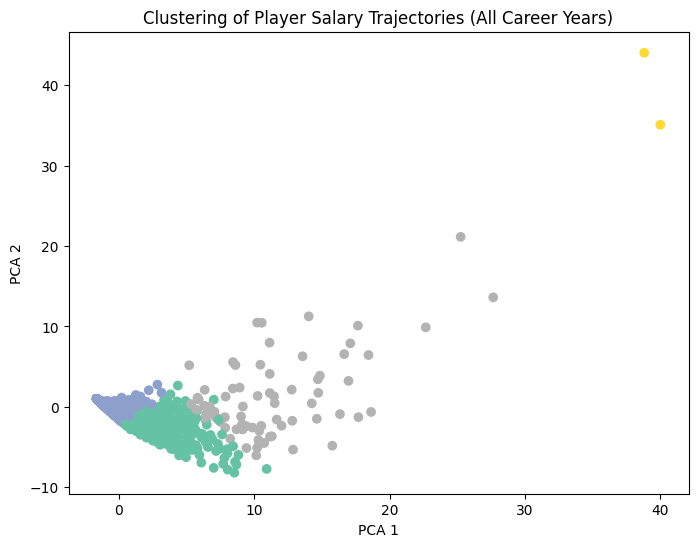

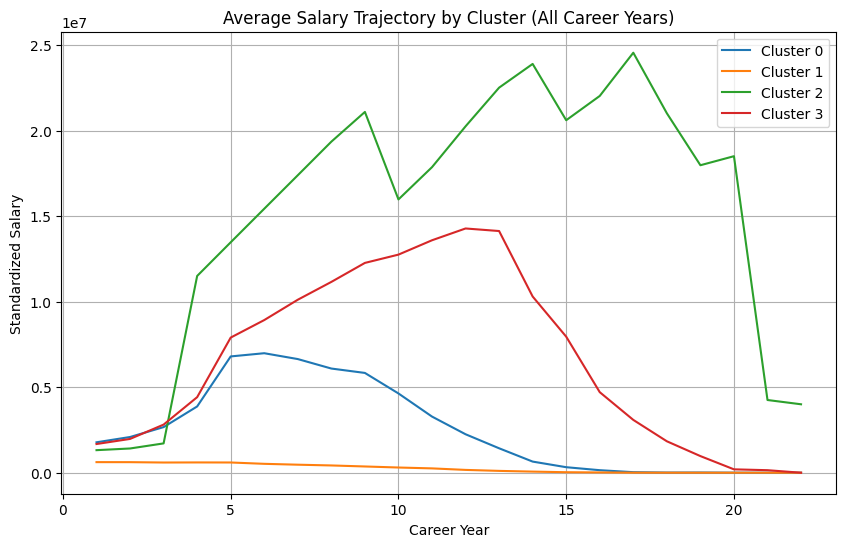

In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("salaries_1985to2018.csv")
players = pd.read_csv("players.csv")

# 清洗薪资数据
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df = df.dropna(subset=['salary'])

# 合并球员信息
merged = df.merge(players, left_on='player_id', right_on='_id', how='left')

# 添加球员生涯年份字段（用于聚类）
merged = merged.sort_values(['player_id', 'season_start'])
merged['career_year'] = merged.groupby('player_id').cumcount() + 1

# pivot 出所有球员的 salary 序列，不限制职业年限
salary_seq = merged.pivot(index='player_id', columns='career_year', values='salary').fillna(0)

# 标准化
scaler = StandardScaler()
salary_scaled = scaler.fit_transform(salary_seq)

# 聚类
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(salary_scaled)

# 添加聚类标签到 salary_seq
salary_seq['cluster'] = labels

# 可视化聚类结果（使用PCA进行降维）
pca = PCA(n_components=2)
salary_pca = pca.fit_transform(salary_scaled)

# 绘制聚类图
plt.figure(figsize=(8, 6))
plt.scatter(salary_pca[:, 0], salary_pca[:, 1], c=labels, cmap='Set2')
plt.title("Clustering of Player Salary Trajectories (All Career Years)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

avg_trajectories = salary_seq.groupby('cluster').mean()

plt.figure(figsize=(10, 6))
for cluster_id, row in avg_trajectories.iterrows():
    # 确保 X 轴范围与每个 cluster 的薪资年份匹配
    career_years = range(1, len(row) + 1)
    plt.plot(career_years, row.values, label=f'Cluster {cluster_id}')

plt.title("Average Salary Trajectory by Cluster (All Career Years)")
plt.xlabel("Career Year")
plt.ylabel("Standardized Salary")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
salary_seq

career_year,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,cluster
player_id,,,,,,,,,,,,,,,,,,,,,
abdelal01,395000.0,494000.0,500000.0,805000.0,650000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
abdulka01,1530000.0,2030000.0,2000000.0,3000000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
abdulma02,1660000.0,2008000.0,2358000.0,1825000.0,2200000.0,2600000.0,3100000.0,3300000.0,798500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
abdulta01,1226880.0,1411000.0,1594920.0,4500000.0,5062500.0,5625000.0,6187500.0,6750000.0,3656250.0,1968750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
abdursh01,2186000.0,9000000.0,10130000.0,11250000.0,12375000.0,13500000.0,14625000.0,5000000.0,5400000.0,5800000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zidekge01,603000.0,694000.0,784200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
zimmest01,950000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
zipsepa01,750000.0,1312611.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [32]:
merged


,index_x,league,player_id,salary,season,season_end,season_start,team,index_y,_id,...,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight,career_year
typing.Literal[<no_default>],,,,,,,,,,,,,,,,,,,,,
0,0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,1
1,1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,2
2,2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,3
3,3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,4
4,4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,0,abdelal01,...,1st round,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,14158,NBA,zipsepa01,750000,2016-17,2017,2016,Chicago Bulls,4679,zipsepa01,...,2nd round,Chicago Bulls,2016,6-8,NaN,Paul Zipser,Small Forward,Right,215lb,1
14159,14159,NBA,zipsepa01,1312611,2017-18,2018,2017,Chicago Bulls,4679,zipsepa01,...,2nd round,Chicago Bulls,2016,6-8,NaN,Paul Zipser,Small Forward,Right,215lb,2
14160,14160,NBA,zizican01,1645200,2017-18,2018,2017,Cleveland Cavaliers,4680,zizican01,...,1st round,Boston Celtics,2016,6-11,NaN,Ante Zizic,Center,Right,254lb,1


cluster_analysis
   cluster                                    position  career_AST   
0        0                                      Center    2.290253  \
1        1                                 Point Guard    1.669123   
2        2  Small Forward and Center and Power Forward    4.176190   
3        3                    Power Forward and Center    3.465902   

   career_FG%  career_FG3%  career_FT%     career_G  career_PER  career_PTS   
0   46.054644    28.000196   74.728806   703.403378   15.084632   11.002437  \
1   44.406276    25.451782   72.308071   468.679408   12.223275    7.111892   
2   47.319048    30.071429   81.185714  1406.761905   22.795238   21.228571   
3   47.542642    28.274921   75.684019  1093.776899   18.997785   16.277532   

   career_TRB      weight  
0    4.764704  224.456936  
1    3.152181  214.111341  
2    7.714286  226.666667  
3    6.408940  224.789557  


<Figure size 1200x600 with 0 Axes>

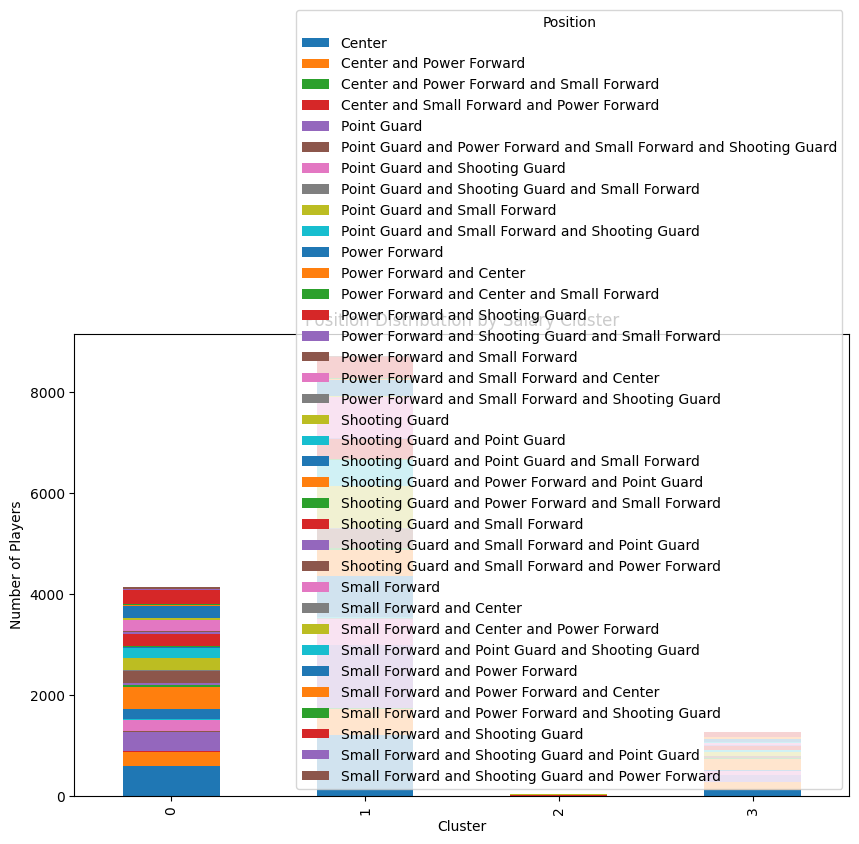

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 假设你已经加载了数据，并进行了聚类操作
# 将聚类标签添加到 salary_seq 中

# 先重置索引，将 'player_id' 从索引列恢复为数据列
salary_seq_reset = salary_seq.reset_index()

# 将聚类标签添加到 salary_seq
salary_seq_reset['cluster'] = kmeans.labels_  # 将聚类标签添加到 salary_seq_reset

# 现在将聚类标签合并回原始的 merged 数据
merged_with_cluster = merged.merge(salary_seq_reset[['player_id', 'cluster']], on='player_id', how='left')
merged_with_cluster = merged_with_cluster.drop(columns=['height'])

# 去除百分号并转换为数值（例如 career_FG% 列）
def clean_percentage_column(df, column_name):
    df[column_name] = df[column_name].replace({'%': '', ',': ''}, regex=True)  # 清除百分号和逗号
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')  # 转换为数值类型

# 对所有相关列进行清理
percentage_columns = ['career_FG%', 'career_FG3%', 'career_FT%', 'career_eFG%']
for col in percentage_columns:
    clean_percentage_column(merged_with_cluster, col)

# 处理其他数值列，确保它们是数值类型
numerical_columns = ['career_PER', 'career_TRB', 'career_WS']
for col in numerical_columns:
    merged_with_cluster[col] = pd.to_numeric(merged_with_cluster[col], errors='coerce')

# 检查清理后的数据


def clean_weight_column(df, column_name):
    df[column_name] = df[column_name].str.replace('lb', '').str.strip()
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

# 清理 weight 列
clean_weight_column(merged_with_cluster, 'weight')

# 检查清理后的 weight 列


# 对每个聚类分析球员的其他属性
cluster_analysis = merged_with_cluster.groupby('cluster').agg({
    'position': lambda x: x.mode()[0],  # 最常见的位置
    'career_AST': 'mean', 
    'career_FG%': 'mean', 
    'career_FG3%': 'mean', 
    'career_FT%': 'mean', 
    'career_G': 'mean', 
    'career_PER': 'mean',  
    'career_PTS': 'mean', 
    'career_TRB': 'mean',  
    'weight': 'mean', 
}).reset_index()

print("cluster_analysis")

# 显示聚类分析结果
print(cluster_analysis)

# 可视化每个聚类中不同位置球员的分布
position_dist = merged_with_cluster.groupby(['cluster', 'position']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
position_dist.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Position Distribution by Salary Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Players")
plt.legend(title="Position")
plt.show()


In [42]:
print(merged_with_cluster.dtypes)


index_x           int64
league           object
player_id        object
salary            int64
season           object
season_end        int64
season_start      int64
team             object
index_y           int64
_id              object
birthDate        object
birthPlace       object
career_AST      float64
career_FG%       object
career_FG3%      object
career_FT%       object
career_G          int64
career_PER       object
career_PTS      float64
career_TRB       object
career_WS        object
career_eFG%      object
college          object
draft_pick       object
draft_round      object
draft_team       object
draft_year       object
height           object
highSchool       object
name             object
position         object
shoots           object
weight           object
career_year       int64
cluster           int32
dtype: object


In [39]:
salary_seq_reset

career_year,player_id,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,cluster
0,abdelal01,395000.0,494000.0,500000.0,805000.0,650000.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,abdulka01,1530000.0,2030000.0,2000000.0,3000000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,abdulma02,1660000.0,2008000.0,2358000.0,1825000.0,2200000.0,2600000.0,3100000.0,3300000.0,798500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,abdulta01,1226880.0,1411000.0,1594920.0,4500000.0,5062500.0,5625000.0,6187500.0,6750000.0,3656250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,abdursh01,2186000.0,9000000.0,10130000.0,11250000.0,12375000.0,13500000.0,14625000.0,5000000.0,5400000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,zidekge01,603000.0,694000.0,784200.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2404,zimmest01,950000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2405,zipsepa01,750000.0,1312611.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2406,zizican01,1645200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [40]:
merged_with_cluster

,index_x,league,player_id,salary,season,season_end,season_start,team,index_y,_id,...,draft_team,draft_year,height,highSchool,name,position,shoots,weight,career_year,cluster
0,0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,0,abdelal01,...,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,1,1
1,1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,0,abdelal01,...,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,2,1
2,2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics,0,abdelal01,...,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,3,1
3,3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics,0,abdelal01,...,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,4,1
4,4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,0,abdelal01,...,Portland Trail Blazers,1990,6-10,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240lb,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,14158,NBA,zipsepa01,750000,2016-17,2017,2016,Chicago Bulls,4679,zipsepa01,...,Chicago Bulls,2016,6-8,NaN,Paul Zipser,Small Forward,Right,215lb,1,1
14159,14159,NBA,zipsepa01,1312611,2017-18,2018,2017,Chicago Bulls,4679,zipsepa01,...,Chicago Bulls,2016,6-8,NaN,Paul Zipser,Small Forward,Right,215lb,2,1
14160,14160,NBA,zizican01,1645200,2017-18,2018,2017,Cleveland Cavaliers,4680,zizican01,...,Boston Celtics,2016,6-11,NaN,Ante Zizic,Center,Right,254lb,1,1
14161,14161,NBA,zubaciv01,1034956,2016-17,2017,2016,Los Angeles Lakers,4683,zubaciv01,...,Los Angeles Lakers,2016,7-1,NaN,Ivica Zubac,Center,Right,240lb,1,1


In [57]:
# 构建序列输入（X）和目标（y）：前5年薪资 → 第6年薪资
full_salary = merged.pivot(index='player_id', columns='career_year', values='salary')
valid_players = full_salary.dropna(subset=[1, 2, 3, 4, 5, 6])  # 至少打到第6年

X_seq = valid_players[[1, 2, 3, 4, 5]].values
y = valid_players[6].values

# 转换为 Tensor
import torch
from torch.utils.data import Dataset, DataLoader

class SalaryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, T, 1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SalaryDataset(X_seq, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


/home/intern/miniconda3/envs/shujun/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
import torch.nn as nn

class SalaryTransformer(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * 5, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        out = self.regressor(x)
        return out.squeeze()


In [60]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 数据准备
full_salary = merged.pivot(index='player_id', columns='career_year', values='salary')
valid_players = full_salary.dropna(subset=[1, 2, 3, 4, 5, 6])  # 至少打到第6年

X_seq = valid_players[[1, 2, 3, 4, 5]].values
y = valid_players[6].values

# 标准化薪资数据
scaler = StandardScaler()
X_seq_scaled = scaler.fit_transform(X_seq)

# 定义 Dataset 类
class SalaryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, T, 1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_seq_scaled, y, test_size=0.2, random_state=42)

train_dataset = SalaryDataset(X_train, y_train)
val_dataset = SalaryDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型定义
class SalaryTransformer(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * 5, 64),
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加 Dropout 防止过拟合
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        out = self.regressor(x)
        return out.squeeze()

# 实例化模型、优化器和损失函数
model = SalaryTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 学习率调度器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# 训练和验证循环
for epoch in range(20):
    model.train()  # 训练模式
    total_loss = 0
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 在每个 epoch 结束时评估模型
    model.eval()  # 验证模式
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            pred = model(X_batch)
            val_loss += loss_fn(pred, y_batch).item()

    # 学习率调度
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")

# 训练结束后，模型可以进行预测


Epoch 1, Train Loss: 938360135745536.0000, Validation Loss: 328081277452288.0000
Epoch 2, Train Loss: 938356894597120.0000, Validation Loss: 328079832514560.0000
Epoch 3, Train Loss: 938350026424320.0000, Validation Loss: 328077192200192.0000
Epoch 4, Train Loss: 938338211069952.0000, Validation Loss: 328072888844288.0000
Epoch 5, Train Loss: 938325911273472.0000, Validation Loss: 328070011551744.0000
Epoch 6, Train Loss: 938314829922304.0000, Validation Loss: 328066742091776.0000
Epoch 7, Train Loss: 938303849234432.0000, Validation Loss: 328063034327040.0000
Epoch 8, Train Loss: 938293852110848.0000, Validation Loss: 328061048324096.0000
Epoch 9, Train Loss: 938286629519360.0000, Validation Loss: 328059014086656.0000
Epoch 10, Train Loss: 938280239497216.0000, Validation Loss: 328056830951424.0000
Epoch 11, Train Loss: 938273551679488.0000, Validation Loss: 328055750918144.0000
Epoch 12, Train Loss: 938270540169216.0000, Validation Loss: 328054656204800.0000
Epoch 13, Train Loss: 938